In [2]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [ ]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

# C1 - Introduction to Human and Computer Vision
## Week 4

In [3]:
# Read pickel file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [4]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_bgr = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    image_qsd1 = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    image_bgr = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    image_nonAugmented = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    image_nonAug_bckg_remov = background_removal(image_nonAugmented)  # Remove background in non-augmented image
   
    QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background

    QSD1_w4_filtered.append(filtered_image)

100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


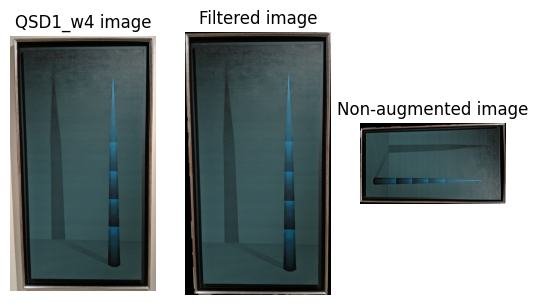

In [5]:
# Plot some examples
img_number = 0


fig, axes = plt.subplots(1, 3)  # 1 fila, 3 columnas

# QSD1_w4 image
axes[0].imshow(QSD1_w4[img_number])
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
axes[1].imshow(QSD1_w4_filtered[img_number][0])
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
axes[2].imshow(QSD1_w4_nonAugmented[img_number][0])  # Rotar 90 grados
axes[2].set_title('Non-augmented image')
axes[2].axis('Off')

plt.show()

### b) Detect keypoints

##### Harris corners

In [ ]:
def harris_corners(image, block_size: int=3, k_size: int=3, k: float=0.04):
    # Split channels
    channels = cv2.split(image)

    # Apply Harris to each channel separately
    harris_r = cv2.cornerHarris(np.float32(channels[0]), block_size, k_size, k)
    harris_g = cv2.cornerHarris(np.float32(channels[1]), block_size, k_size, k)  
    harris_b = cv2.cornerHarris(np.float32(channels[2]), block_size, k_size, k)  

    # Combinar resultados de Harris de los tres canales tomando el máximo valor en cada posición
    harris_combined = np.maximum(np.maximum(harris_r, harris_g), harris_b)

    # Improve results applying a Dilation (ns pq però diuen que millora)
    harris_combined = cv2.dilate(harris_combined, None)

    # Mark corners
    corner_image = np.copy(image)
    threshold = 0.01 * harris_combined.max()
    corner_image[harris_combined > threshold] = [255, 0, 0]

    return corner_image


#### Harris Laplacian

In [7]:
def harris_laplacian(image, block_size: int=2, k_size: int=3, k: float=0.04, num_scales: int=5, scale_factor: float=1.2):

    channels = cv2.split(image)

    # Compute Harris detector on each channel at multiple scales
    harris_responses = []
    for scale in range(num_scales):
        scale_responses = []
        scale_factor_pow = scale_factor ** scale  # Current scaling factor
        
        for channel in channels:
            # Resize the channel to the current scale size
            resized_channel = cv2.resize(channel, None, fx=scale_factor_pow, fy=scale_factor_pow, interpolation=cv2.INTER_LINEAR)
            
            # Apply the Harris detector on the resized channel
            harris_response = cv2.cornerHarris(np.float32(resized_channel), block_size, k_size, k)
            
            # Resize the Harris response back to the original scale
            harris_response = cv2.resize(harris_response, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
            scale_responses.append(harris_response)
        
        # Take the maximum response across color channels for this scale and add it to the list of responses
        max_response = np.maximum.reduce(scale_responses)
        harris_responses.append(max_response)

    # Find local maxima in space and scale using a Laplacian-like approach
    # Here, we look for maxima across 3 dimensions (x, y, scale)
    harris_responses = np.array(harris_responses)
    final_response = np.max(harris_responses, axis=0)  # Max across scales

    # Apply a threshold to mark detected corners in the original image
    corner_image = np.copy(image)
    threshold = 0.01 * final_response.max()
    corner_image[final_response > threshold] = [255, 0, 0]  # Mark in red

    return corner_image


#### Difference of Gaussians

In [ ]:
def difference_of_gaussians(image, k: float=np.sqrt(2), num_scales: int=5, initial_sigma: float=1.0):
    channels = cv2.split(image)

    # Compute DoG on each channel at multiple scales
    dog_responses = []
    for channel in channels:
        gaussians = []
        
        # Generate Gaussian-blurred images at each scale
        for scale in range(num_scales + 1):  # +1 to have an extra Gaussian for DoG
            sigma = initial_sigma * (k ** scale)
            gaussian_blurred = cv2.GaussianBlur(channel, (0, 0), sigma)
            gaussians.append(gaussian_blurred)
        
        # Compute the Difference of Gaussians (DoG) for each consecutive pair of blurred images
        for i in range(num_scales):
            dog = cv2.absdiff(gaussians[i], gaussians[i + 1])  # DoG as absolute difference
            dog_responses.append(dog)

    # Combine DoG responses across color channels by taking the maximum across channels
    dog_combined = np.maximum.reduce(dog_responses)

    # Threshold the combined DoG response to detect keypoints
    threshold = 0.05 * dog_combined.max()
    keypoints_image = np.copy(image)
    keypoints_image[dog_combined > threshold] = [255, 0, 0]  # Mark keypoints in red

    return keypoints_image


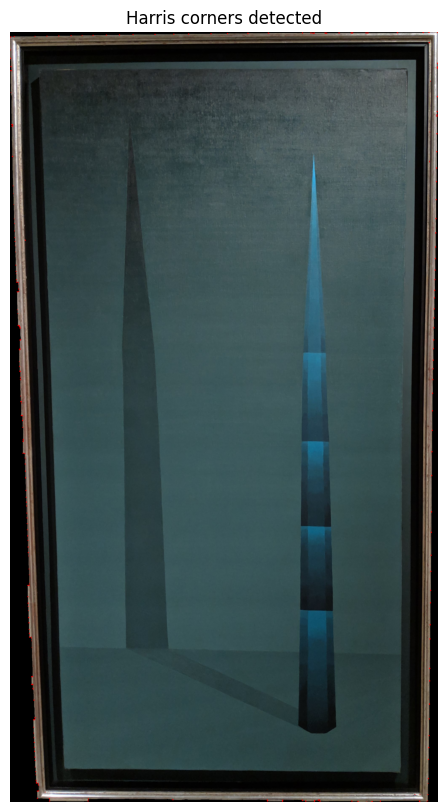

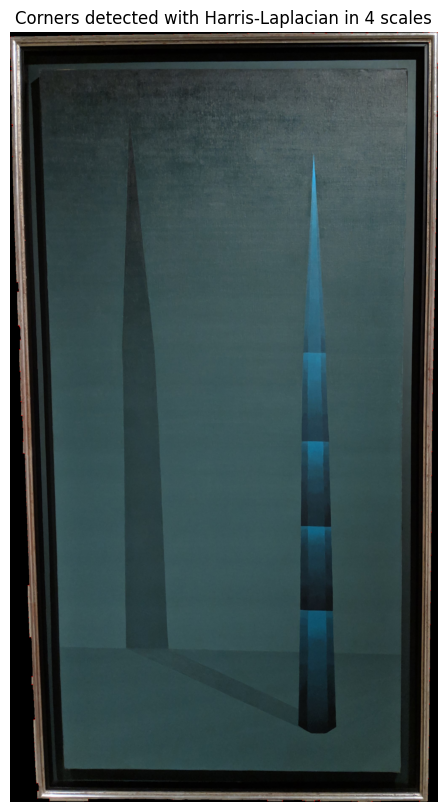

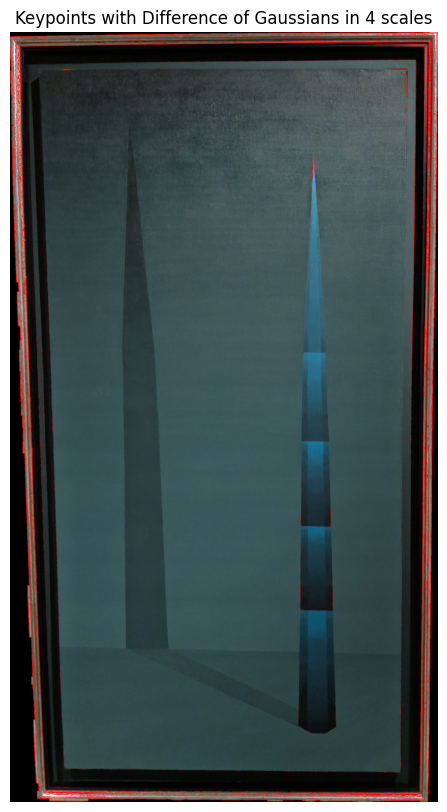

In [15]:
image = QSD1_w4_filtered[img_number][0]

params = {
    'block_size': 3,
    'k_size': 3,
    'k': 0.04,
    'num_scales': 4,
    'scale_factor': np.sqrt(2),
    'initial_sigma': 1.0,
}


harris_corner_image = harris_corners(image, params['block_size'], params['k_size'], params['k'])
harris_laplacian_image = harris_laplacian(image, params['block_size'], params['k_size'], params['k'], params['num_scales'], params['scale_factor'])
keypoints_image = difference_of_gaussians(image, params['k'], params['num_scales'], params['initial_sigma'])

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(harris_corner_image)
plt.title('Harris corners detected')
plt.axis('off')
plt.show()

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(harris_laplacian_image)
plt.title(f'Corners detected with Harris-Laplacian in {params["num_scales"]} scales')
plt.axis('off')
plt.show()

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(keypoints_image)
plt.title(f'Keypoints with Difference of Gaussians in {params["num_scales"]} scales')
plt.axis('off')
plt.show()

### c) Compute descriptors in Museum and query images

# Task 2

### a) Find tentative matches based on similarity of local appearance and verify matches 

### b) Implement a system to discard queries not in the data set (unknowns)

# Task 3

### a) Evaluate system based on keypoint descriptors on QSD1-W4

### b) Compare your best query system from previous week on QSD1-W4

# Task 4

### a) Create pkl file